In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from joblib import load, dump

In [3]:
torch.__version__

'1.7.0'

# Loading Data

In [4]:
y = torch.load("Objects/labels.pt")
X = torch.load("Objects/glove_embeddings.pt")

In [5]:
X = pad_sequence(X, batch_first=True)

In [6]:
class Data(Dataset):
    def __init__(self):
        self.x = X
        self.y = y
        
        self.n_samples = len(y)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.n_samples

In [7]:
data = Data()

In [8]:
train_data, test_data = random_split(data, [4400, 446])

In [9]:
batch_size = 5

In [10]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Helper Functions

In [11]:
# Gets the lengths of all of the sequences in a batch
def get_lengths(features):
    num_pads = 0
    length_list = []
    for i in features:
        for j in range(88):
            if torch.sum(i[j] == 0).item() == 300:
                num_pads += 1
        length = 88 - num_pads
        length_list.append(length)
        num_pads = 0
    return length_list


In [12]:
# convert output matrix into categories
# i.e [0.1, 3, -0.1] ----> 'Neutral'

def get_category(output_matrix):
  
    outputs = []
    
    cat_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    
    for i in output_matrix:
        val = torch.argmax(i).item()
        outputs.append(cat_map[val])
    
    return outputs

# Define Architechture

In [13]:
# Typical RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_tensor):
        h0 = torch.zeros(self.num_layers, 10, self.hidden_size)
        
        output, h_n = self.rnn(input_tensor, h0)
        
        output = pad_packed_sequence(output, batch_first=True)
        
        # length of sequences
        indices = output[1] - 1 
        
        # update batch size (if its the last batch, the size will be different)
        current_batch_size = output[0].size()[0]
        
        output = output[0][range(current_batch_size), indices, :]
        
        output = self.linear1(output)
        
        return output

In [14]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_tensor):
        h0 = torch.zeros(self.num_layers, 10, self.hidden_size)
        
        output, h_n = self.rnn(input_tensor, h0)
        
        output = pad_packed_sequence(output, batch_first=True)
        
        # length of sequences
        indices = output[1] - 1 
        
        # update batch size (if its the last batch, the size will be different)
        current_batch_size = output[0].size()[0]
        
        output = output[0][range(current_batch_size), indices, :]
        
        output = self.linear1(output.view(current_batch_size,64))
        
        return output

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear1 = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_tensor):
        
        h0 = torch.zeros(self.num_layers, 10, self.hidden_size)
        c0 = torch.zeros(self.num_layers, 10, self.hidden_size)
        output, (h_n, c_n) = self.rnn(input_tensor, (h0, c0))
        
        
        output = pad_packed_sequence(output, batch_first=True)
        
        # length of sequences
        indices = output[1] - 1 
        
        # update batch size (if its the last batch, the size will be different)
        current_batch_size = output[0].size()[0]
        
        output = output[0][range(current_batch_size), indices, :]
        
        output = self.linear1(output.view(current_batch_size,64))
        
        return output

## hyperparameters

In [38]:
num_epochs = 3
hidden_size = 64
output_size = 3
input_size = 300
num_layers = 1

## Example Forward pass

In [17]:
example_rnn = RNN(input_size, hidden_size, num_layers, output_size)

In [18]:
example_data = iter(train_loader).next()

In [19]:
print(f'Shape of Data: {example_data[0].size()}')
print(f'Labels: {example_data[1]}')

# example_data is a padded sequence of glove word embeddings

# -> [0.1, -1, 2, -0.23, ... -0.12, 1.22, 0.01] 300 dimensional embeddings with 88 being the longest sequence
# -> [-0.1, 0, 1, -0.21, ... -0.1, 0, 0.1, 0.1]
# -> [0, 0, 0, 0, ... -0, 0, 0] # seequences shorter than 88 have a padding value of 0

Shape of Data: torch.Size([5, 88, 300])
Labels: tensor([0, 1, 1, 1, 1])


In [20]:
# first we need to pack the sequence using pytorch's packed sequence

# 1.) get feature lengths
feature_lengths = get_lengths(example_data[0])
                                    
# 2.) pack the sequence; Parameters --> batch_first: ensures the batch size is first dimension, enforse_sorted: allows for unsorted sequence
packed = pack_padded_sequence(example_data[0], feature_lengths, batch_first = True, enforce_sorted=False)

this creates a pytorch [PackedSequence]("https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.PackedSequence.html#torch.nn.utils.rnn.PackedSequence") object, and you can click the link to the documentation. All pytorch recurrent layers accept this data type as an input. This is very useful because we can pass sequences of variable length into our network and we can train on the orginal sequence instead of a padded sequence. Here we will pass a sample batch from our training data as a packed sequence through an RNN network. 

In [21]:
output = example_rnn(packed.float())
print(output)

tensor([[0.0308, 0.2140, 0.2694],
        [0.1583, 0.0355, 0.1937],
        [0.0646, 0.4017, 0.1098],
        [0.2099, 0.4175, 0.0037],
        [0.2174, 0.2103, 0.0953]], grad_fn=<AddmmBackward>)


In [22]:
# get predictions as category
get_category(output)

['positive', 'positive', 'neutral', 'neutral', 'negative']

In [23]:
# actual values
example_data[1]

tensor([0, 1, 1, 1, 1])

# Training

In [24]:
learning_rate = 0.001

In [25]:
rnn = RNN(input_size, hidden_size, num_layers, output_size)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [39]:
# Training loop
n_total_steps = np.ceil(len(train_data) / batch_size)
all_losses = []
loss_step = 25
current_loss = 0

for epoch in range(num_epochs):
    for i, (feature, label) in enumerate(train_loader):
        
        # pack seequence
        sequence_lengths = get_lengths(feature)
        
        packed = pack_padded_sequence(feature, sequence_lengths, batch_first=True, enforce_sorted=False)
       
        # forward pass
        output = rnn(packed.float())
        
        #backward pass
        loss = criterion(output, label)
        loss.backward()
        current_loss += loss
        
        #update weights
        optimizer.step()
        optimizer.zero_grad()
        
        # Store Average Losses for plotting
        if (i+1) % loss_step == 0:
            avg_loss = current_loss / loss_step
            all_losses.append(avg_loss.item())
            current_loss = 0

        #log results
        if (i+1) % 100 == 0:
            print(f'Epoch: {epoch} --- Step:{i+1} / {n_total_steps} --- Loss: {all_losses[-1]}') 
            pass
        

Epoch: 0 --- Step:100 / 880.0 --- Loss: 0.2861466109752655
Epoch: 0 --- Step:200 / 880.0 --- Loss: 0.2176736295223236
Epoch: 0 --- Step:300 / 880.0 --- Loss: 0.4385327100753784
Epoch: 0 --- Step:400 / 880.0 --- Loss: 0.22246412932872772
Epoch: 0 --- Step:500 / 880.0 --- Loss: 0.4390706717967987
Epoch: 0 --- Step:600 / 880.0 --- Loss: 0.431161493062973
Epoch: 0 --- Step:700 / 880.0 --- Loss: 0.39117947220802307
Epoch: 0 --- Step:800 / 880.0 --- Loss: 0.30643898248672485
Epoch: 1 --- Step:100 / 880.0 --- Loss: 0.24757488071918488
Epoch: 1 --- Step:200 / 880.0 --- Loss: 0.33308136463165283
Epoch: 1 --- Step:300 / 880.0 --- Loss: 0.2779686450958252
Epoch: 1 --- Step:400 / 880.0 --- Loss: 0.28917136788368225
Epoch: 1 --- Step:500 / 880.0 --- Loss: 0.35221168398857117
Epoch: 1 --- Step:600 / 880.0 --- Loss: 0.2087370753288269
Epoch: 1 --- Step:700 / 880.0 --- Loss: 0.38686808943748474
Epoch: 1 --- Step:800 / 880.0 --- Loss: 0.44480788707733154
Epoch: 2 --- Step:100 / 880.0 --- Loss: 0.475831

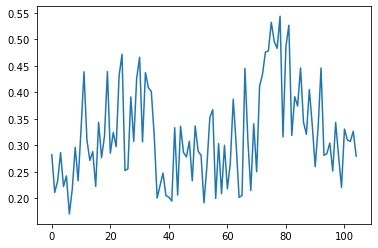

In [40]:
plt.plot(all_losses)
plt.show()

# Model Evaluation

In [41]:
with torch.no_grad():
    predictions = []
    labels = []
    for (feature, label) in test_loader:
        
        #pack sequence
        sequence_lengths = get_lengths(feature)
        packed = pack_padded_sequence(feature, sequence_lengths, batch_first=True, enforce_sorted=False)
        
        # forward pass
        output = rnn(packed.float())
        
        for i in range(output.size()[0]):
            pred = torch.argmax(output[i]).item()
            predictions.append(pred)
            actual = label[i]
            labels.append(actual)

In [42]:
total_acc = accuracy_score(predictions, labels)

In [43]:
confusion_matrix(predictions, labels)

array([[ 15,   4,  11],
       [ 24, 213,  70],
       [ 27,  37,  45]])

## Logging Model

In [44]:
total_acc

0.6121076233183856

In [ ]:
rnn

In [ ]:
log_entry = {
    'model': rnn,
    'features': 'glove embeddings',
    'model_type': 'LSTM',
    'num_layers': 1,
    'layers': ["LSTM", "Linear"],
    'activation': ["tanh", None],
    'dropout': [None, None],
    'epochs': 15,
    'acc': total_acc,
    'notes': 'LSTM baseline'
    
}

In [ ]:
model_log = []

In [ ]:
model_log.append(rnn)

In [ ]:
model_log